In [1]:
from pathlib import Path
notebook_path = Path().cwd().parent.parent.parent.parent
import sys; sys.path.insert(0, str(notebook_path))

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# custom functions
from explore.gcp.storage import gcp
from explore.src.utilities.eda_funcs import describe_data
from explore.src.visualisation.valuations_visual import PlayerValsPlots
from explore.src.preprocess.clean_valuations import CleanPlayerVals

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# read in ligue 1 data
df = gcp.read_df_from_bucket(bucket_name='processed_transfermarkt_db', blob_name='processed_ligue_1_player_valuations.csv')

[03/21/24 18:17:27] INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:28 ] - Getting GCP bucket                                 ]8;id=886531;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=581851;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#28\28]8;;\

[03/21/24 18:17:28] INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:33 ] - GCP bucket retrieved                               ]8;id=615008;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=365496;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#33\33]8;;\

In [3]:
df.head()

,tm_id,tm_name,player,squad_num,position,age,country,current_club,height,foot,signed_date,signed_from,signing_fee_euro_mill,contract_expiry,market_value_euro_mill,season,league,team,signed_year,player_id
0,120629,alphonse-areola,Alphonse Areola,16,Goalkeeper,25,France,West Ham United,195.0,right,"Jul 1, 2010",Paris Saint-Germain U19,NaN,NaN,15.0,2017,ligue_1,fc-paris-saint-germain,2010.0,112.0
1,45672,kevin-trapp,Kevin Trapp,1,Goalkeeper,27,Germany,Eintracht Frankfurt,189.0,right,"Jul 8, 2015",Eintracht Frankfurt,9.5,NaN,8.0,2017,ligue_1,fc-paris-saint-germain,2015.0,2381.0
2,282028,remy-descamps,Rémy Descamps,0,Goalkeeper,22,France,FC Nantes,196.0,left,"Jul 1, 2017",Paris Saint-Germain B,NaN,NaN,0.6,2017,ligue_1,fc-paris-saint-germain,2017.0,5463.0
3,395251,sebastien-cibois,Sébastien Cibois,40,Goalkeeper,20,France,Rodez AF,192.0,right,"Jul 1, 2018",Paris Saint-Germain B,NaN,NaN,NaN,2017,ligue_1,fc-paris-saint-germain,2018.0,4131.0
4,181767,marquinhos,Marquinhos,5,Centre-Back,24,Brazil,Paris Saint-Germain,183.0,right,"Jul 19, 2013",AS Roma,31.4,NaN,55.0,2017,ligue_1,fc-paris-saint-germain,2013.0,1492.0


In [4]:
describe_data(df)

,Data Types,Null Counts,Null %,Unique Values,Min,Max,Median,Mean,Std Dev,Outliers,Outliers %
tm_id,int64,0,0.00,2116,1667.0,1176345.0,341647.0,372593.73,248489.10,14,0.29
squad_num,int64,0,0.00,71,0.0,99.0,11.0,14.29,14.92,73,1.50
age,int64,0,0.00,28,16.0,43.0,24.0,24.69,4.75,16,0.33
height,float64,0,0.00,42,162.0,206.0,182.0,181.91,6.60,15,0.31
signing_fee_euro_mill,float64,1627,33.51,151,0.0,222.0,1.0,5.12,14.91,376,7.74
market_value_euro_mill,float64,244,5.03,119,0.1,200.0,2.5,5.88,11.78,418,8.61
season,int64,0,0.00,7,2017.0,2023.0,2020.0,2019.91,1.93,0,0.00
signed_year,float64,367,7.56,22,2002.0,2024.0,2019.0,2018.78,2.76,37,0.76
player_id,float64,1149,23.67,1413,4.0,6295.0,2580.0,2712.58,1667.18,0,0.00


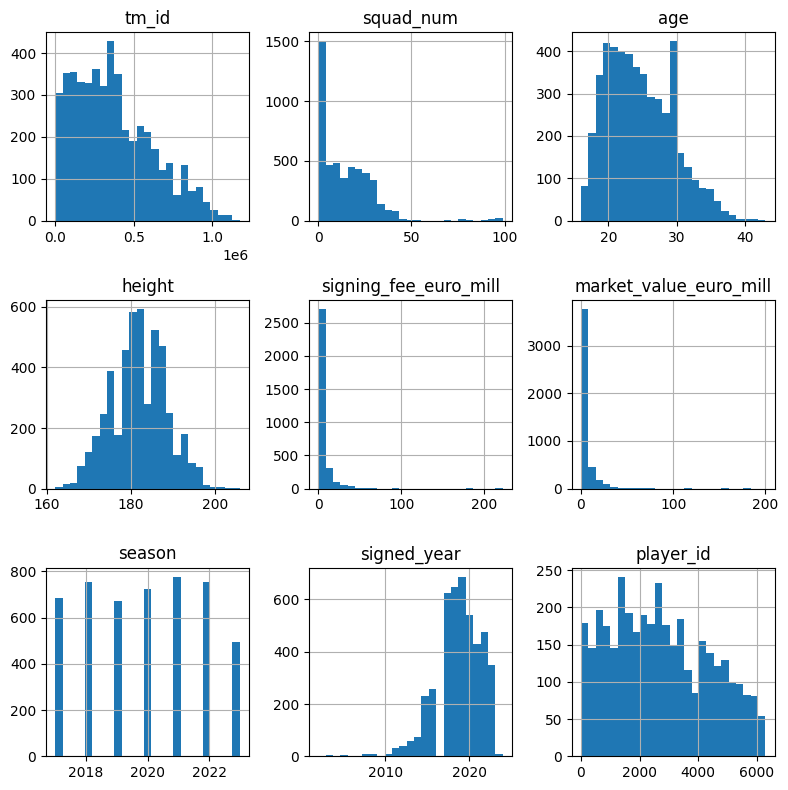

In [5]:
# plot distributions of the data
df.hist(bins=25, figsize=(8,8))
plt.tight_layout()
plt.show()

In [7]:
# initialise plotter
plots = PlayerValsPlots(df)

## Position Analysis

In [8]:
plots.valuation_plot('position')

## Country Analysis

In [9]:
plots.valuation_plot('country')

In [10]:
# plot total players for each season by country - timeseries
plots.var_totals_plot('country')

## Team Analysis

In [11]:
plots.valuation_plot('team')

In [12]:
# for each season, get the average difference between signing fee and market value for the players that were signed by team
dfs = []
for year in df["season"].unique():
    dff = df.loc[(df["season"] == year) & (df["signed_year"] == year)]
    dff.loc[:, "diff_sign_fee_mv"] = (
        dff["market_value_euro_mill"] - dff["signing_fee_euro_mill"]
    )
    dfff = (
        dff.groupby("team")["diff_sign_fee_mv"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    dfff.loc[:, "season"] = year
    dfs.append(dfff)

df_diff_sign_fee_mv = pd.concat(dfs)

df_diff_sign_fee_mv.head()

,team,diff_sign_fee_mv,season
0,olympique-lyon,8.071429,2017
1,olympique-marseille,4.225000,2017
2,montpellier-hsc,2.750000,2017
3,dijon-fco,2.735714,2017
4,ogc-nizza,2.633333,2017


In [13]:
px.line(
    df_diff_sign_fee_mv,
    x="season",
    y="diff_sign_fee_mv",
    color="team",
    title="Average difference between signing fee and end of season market value over time",
)

## Signing Value Analysis

In [14]:
plots.plot_diff_val_paid('team')

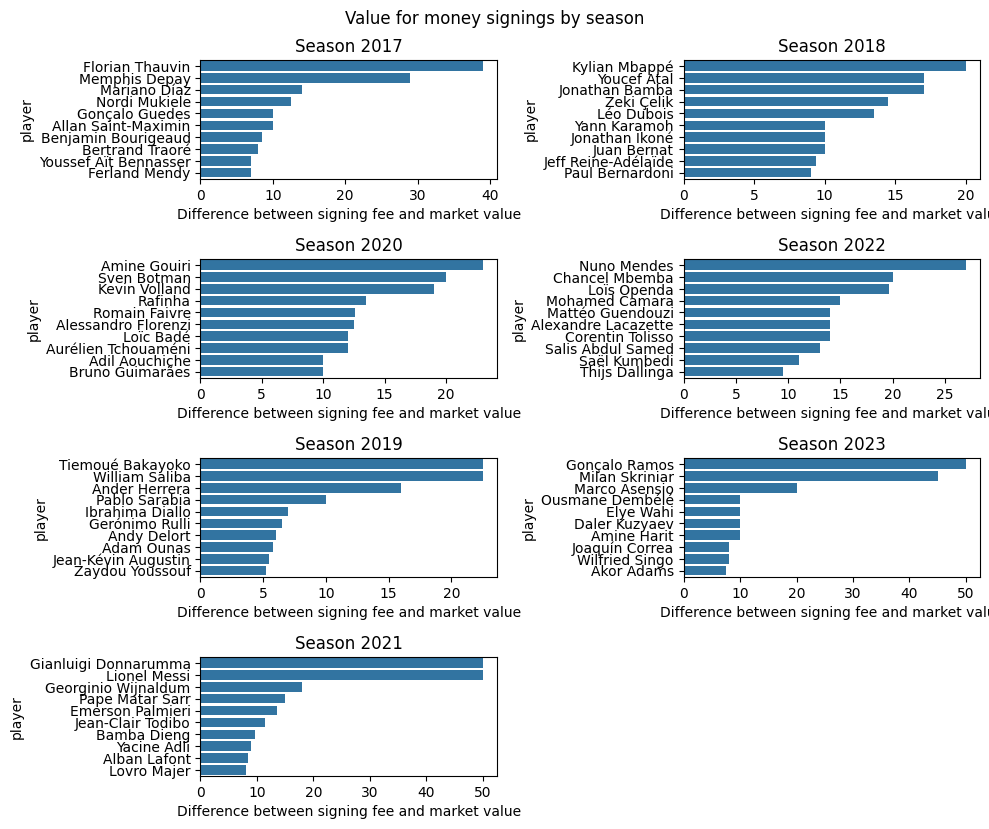

In [15]:
plots.plot_value_signings()

## Height Analysis

In [16]:
plots.valuation_plot('height')

## Foot Analysis

In [17]:
plots.valuation_plot('foot')

## Age Analysis

In [18]:
plots.valuation_plot('age')

In [19]:
plots.plot_diff_val_paid('age')